In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import os
from glob import glob
from itertools import chain
import decimal


from skimage.feature import hog
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.cross_validation import train_test_split
# from sklearn.grid_search import GridSearchCV
from scipy.ndimage.measurements import label
import time

# from os import path

%matplotlib inline

print("All libraries are loaded.")

All libraries are loaded.


# ETL
I'm going to load the training samples with which I will train the classifier. These example images come from a combination of the GTI vehicle image database, the KITTI vision benchmark suite, and examples extracted from the project video itself.

In [2]:
path_to_vehicles = "./dataset/vehicles/"
path_to_nonvehicles = "./dataset/non-vehicles/"

"""
This method is for when I want to load all image file paths into memory
"""
def file_list(path):
    return [y for x in os.walk(path) for y in glob(os.path.join(x[0], '*.png'))]

"""
This method is for when I want to get a generator of all image file paths 
"""
def file_generator(path):
    return (chain.from_iterable(glob(os.path.join(x[0], '*.png')) for x in os.walk('.')))

vehicles = file_list(path_to_vehicles)
non_vehicles = file_list(path_to_nonvehicles)

print(len(vehicles))
print(type(vehicles[0]))
print(len(non_vehicles))
print(type(non_vehicles[0]))

8792
<class 'str'>
8968
<class 'str'>


In [3]:
# parameters used in the phase of feature extraction
feat_extraction_params = {'color_space': 'YCrCb',      # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, BGR
                          'orient': 9,                 # HOG orientations
                          'pix_per_cell': 8,           # HOG pixels per cell
                          'cell_per_block': 2,         # HOG cells per block
                          'spatial_size': (32, 32),    # Spatial binning dimensions
                          'nbins': 16,                 # Number of histogram bins
                          'hog_channel': "ALL",        # Can be 0, 1, 2, or "ALL"
                          'spatial_feat': True,        # Spatial features on or off
                          'hist_feat': True,           # Histogram features on or off
                          'hog_feat': True,            # HOG features on or off
                          'feature_vec' : True ,       # Call ravel() automatically or not,
                          'transform_sqrt': False,     # Turn "gamma" normalization on or off
                          'visualize': False}          # Turn on visualization or off 

In [ ]:
def read_image(image_name):
    return mpimg.imread(image_name)

In [4]:
def convert_color(img, conv='YCrCb'):
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR':
        return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True, transform_sqrt = False):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=transform_sqrt, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=transform_sqrt, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [6]:
def bin_spatial(img, size=(32, 32)):
    
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    
    return np.hstack((color1, color2, color3))

In [7]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [8]:
# Consider using multiple threads here to speed this process up
def load_features(image):
    # loading dictionary values
    color_space = feat_extraction_params['color_space']
    
    orient = feat_extraction_params['orient']
    pix_per_cell = feat_extraction_params['pix_per_cell']
    cell_per_block = feat_extraction_params['cell_per_block']
    spatial_size = feat_extraction_params['spatial_size']
    nbins = feat_extraction_params['nbins']
    
    hog_channel = feat_extraction_params['hog_channel']
    
    feature_vec = feat_extraction_params['feature_vec']
    transform_sqrt = feat_extraction_params['transform_sqrt']
    visualize = feat_extraction_params['visualize']
    
    spatial_feat = feat_extraction_params['spatial_feat']
    hist_feat = feat_extraction_params['hist_feat']
    hog_feat = feat_extraction_params['hog_feat']
    
    
    #1) Define an empty list to receive features
    features = []
    
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        img = convert_color(image, conv=color_space)
    else: 
        feature_image = np.copy(img)      
    
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(img, size=spatial_size)
        
        #4) Append features to list
        features.append(spatial_features)
    
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(img, nbins=nbins)
        
        #6) Append features to list
        features.append(hist_features)
    
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(img.shape[2]):
                hog_features.extend(get_hog_features(img[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(img[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(features)

In [9]:
def feature_extraction(file_list):
    
    # features will be stores in a list
    features = []
    
    for file in file_list:
        # print(file)
        img = read_image(file)
        
        features.append(load_features(img))
    
    return features

In [10]:
Xfilename = "./variables/X_values.npy"
yfilename = "./variables/y_values.npy"
loaded = False

In [11]:
if ((os.path.isfile(Xfilename) != True) and (os.path.isfile(yfilename) != True)): 
    # reassigning the vehicles and non_vehicles variable because I no longer need the paths to the images
    # better to free that memory up
    t1 = time.time()
    vehicles = feature_extraction(vehicles)
    t2 = time.time()
    print("Vehicles processing took", (t2-t1), "seconds.")
    t3 = time.time()
    non_vehicles = feature_extraction(non_vehicles)
    t4 = time.time()
    print("Non-Vehicles processing took", (t4-t3), "seconds.")

In [12]:
print(type(vehicles))
print(len(vehicles))
print(type(non_vehicles))
print(type(vehicles[0]))
print(type(non_vehicles[0]))
print(vehicles[0].shape)
print(non_vehicles[0].shape)

<class 'list'>
8792
<class 'list'>
<class 'str'>
<class 'str'>


AttributeError: 'str' object has no attribute 'shape'

In [13]:
print(non_vehicles[0][0])
print(type(non_vehicles[0][0]))

.
<class 'str'>


In [14]:
if ((os.path.isfile(Xfilename) != True) and (os.path.isfile(yfilename) != True)):
    print("loading from images")
    tup = (vehicles, non_vehicles)
    X = np.vstack(tup)
    # X = np.array(X, dtype = np.float64)                        
    # Fit a per-column scaler
    # X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    # X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(vehicles)), np.zeros(len(non_vehicles))))


    print(X.shape)
    print(y.shape)
else:
    print("Loading from file...")
    y = np.load(yfilename)
    print("Finished loading y!")
    X = np.load(Xfilename)
    print("Finished loading X!")
    loaded = True
    print(X.shape)
    print(y.shape)

Loading from file...
Finished loading y!
Finished loading X!
(17760, 8412)
(17760,)


In [15]:
if loaded != True:
    np.save(Xfilename, X)
    np.save(yfilename, y)
    loaded = True
    print("X and y saved.")
    print(X.shape)
    print(y.shape)

In [16]:
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
X = X_scaler.transform(X)

In [17]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

In [18]:
model_save = "./model/model.pkl"
loaded = False

In [19]:
def drange(x, y, jump):
    while x < y:
        yield float(x)
        x += decimal.Decimal(jump)
c_vars = list(drange(1, 10, '0.5'))
parameters = {'kernel':('linear', 'rbf', 'sigmoid', 'poly'), 
              'C':c_vars}

In [20]:
if (os.path.isfile(model_save) != True):
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    clf = svm.LinearSVC()
    # clf = GridSearchCV(svc, parameters)
    # Check the training time for the SVC
    t=time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    print("Prediction took:", (t-t2), "seconds")

Feature vector length: 8412
41.69 Seconds to train SVC...
Test Accuracy of SVC =  0.9797
Prediction took: 0.06812715530395508 seconds
model saved


In [ ]:
if (os.path.isfile(model_save) != True):
    joblib.dump(clf, model_save) 
    print("model saved")
else:
    print("loading from file")
    clf = joblib.load(model_save) 
    print("model loaded")

In [21]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, nbins, visualize = False):
    
    windows = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), 
        np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient * cell_per_block ** 2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    if visualize:
        hog1, out1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec = False,
                                      vis = visualize)
        hog2, out2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec = False,
                                      vis = visualize)
        hog3, out3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec = False,
                                      vis = visualize)
        plt.imshow(out1, cmap = 'gray')
        plt.show()
        plt.imshow(out2, cmap = 'gray')
        plt.show()
        plt.imshow(out3, cmap = 'gray')
        plt.show()
    else:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec = False, vis = visualize)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec = False, vis = visualize)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec = False, vis = visualize)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=nbins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            # print(test_prediction)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                # cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
                top_left = (xbox_left, ytop_draw + ystart)
                bottom_right = (xbox_left + win_draw, ytop_draw + win_draw + ystart)

                windows.append((top_left, bottom_right))
                
    return windows

In [22]:
ystart = 400
ystop = 656
scale = 1

6
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 1.]
[ 0.]
[ 0.]
[ 0.]
[ 1.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 1.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]


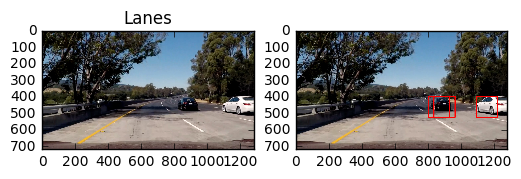

[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 1.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 1.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]


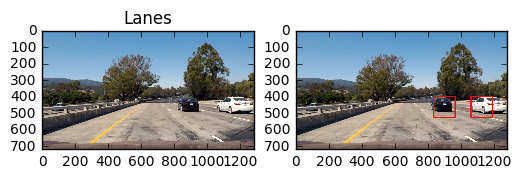

[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 1.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 1.]
[ 0.]
[ 0.]
[ 0.]
[ 1.]
[ 1.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]


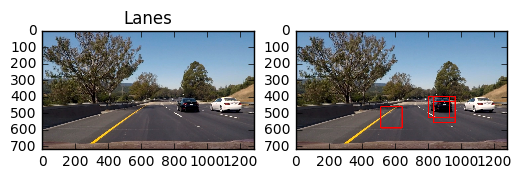

[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]


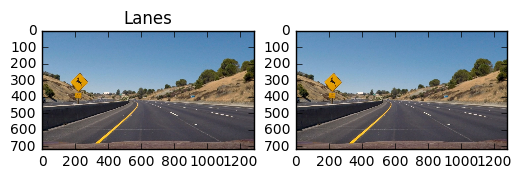

[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 1.]
[ 1.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]


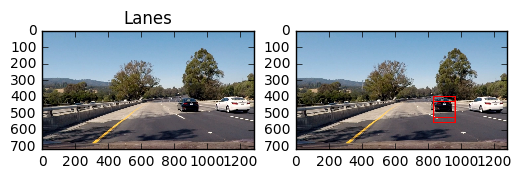

[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 1.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]


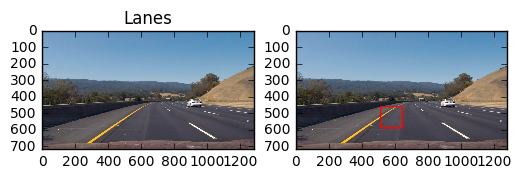

In [23]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        # print(box)
        x_min, y_min = box[0]
        x_max, y_max = box[1]
        heatmap[y_min:y_max, x_min:x_max] += 1 # add heat

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [ ]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [ ]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), 
        np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [ ]:
test_images = "./test_images/"
test_files = [y for x in os.walk(test_images) for y in glob(os.path.join(x[0], '*.jpg'))]
print(len(test_files))

for img in test_files:
    img = read_image(img)
    
    draw_img = np.copy(img)
    
    orient = feat_extraction_params['orient']
    pix_per_cell = feat_extraction_params['pix_per_cell']
    cell_per_block = feat_extraction_params['cell_per_block']
    spatial_size = feat_extraction_params['spatial_size']
    nbins = feat_extraction_params['nbins']
    
    windows = []
    
    for scale in np.arange(1, 3, 0.5):
        found = find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, 
                            spatial_size, nbins, visualize = True)
        
        for top_left, bottom_right in found:
            cv2.rectangle(draw_img, top_left, bottom_right, (0, 0, 255), 6)
        
        windows.extend(found)
        

    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(img)
    ax[0].set_title("Original")
    ax[1].imshow(draw_img)
    ax[1].set_title("Lanes")
    plt.show()
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(draw_img)
    ax[0].set_title('Car Positions')
    ax[1].imshow(heatmap, cmap='hot')
    ax[1].set_title('Heat Map')
    plt.show()

In [ ]:
def pipeline(img):
    orient = feat_extraction_params['orient']
    pix_per_cell = feat_extraction_params['pix_per_cell']
    cell_per_block = feat_extraction_params['cell_per_block']
    spatial_size = feat_extraction_params['spatial_size']
    nbins = feat_extraction_params['nbins']
    
    windows = []
    
    for scale in np.arange(1, 3, 0.5):
        found = find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, 
                            spatial_size, nbins, visualize = True)
        windows.extend(found)
        
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    return draw_labeled_bboxes(np.copy(img), labels)